In [22]:
import math
import numpy as np
import pandas as pd
from mapie.classification import MapieClassifier
from mapie.metrics import classification_coverage_score, classification_mean_width_score
import matplotlib.pyplot as plt
import json

from src.model import MockModel
from src.utils import index_for_arange, write_results, cq_labels, cq_filter
import src.plot as plot
from src.eval import (
    adjusted_classification_x_width_score,
    size_stratified_classification_coverage_score,
    cq_stats,
    set_size_equals,
)
from src.heuristics import TopKSelector, HeuristicCutoffSelector, TopKCutoffSelector

In [23]:
import pandas as pd
dataset = 'banking77'
intent_classifier = 'dfcx'

In [24]:
data_dir = "data/banking77/dfcx/"

# NOTE: we do not need predictions on the train set, but they can be included for completeness
#df_train_preds = pd.read_csv("dfcx_banking77/calibration_sample.csv").reset_index() # change to file with confidence scores on train set
df_test_preds = pd.read_csv(data_dir + "test_predictions.csv").reset_index()
df_calibration_preds = pd.read_csv(data_dir + "calibration_predictions.csv").reset_index()

N_INTENTS = 77

In [25]:
label_names = list(lambda x: 'label_{}'.format(x) for x in range(N_INTENTS))

In [26]:
df_test = df_test_preds.reset_index().rename(columns={'level_0': 'utterance'})
df_calibration = df_calibration_preds.reset_index().rename(columns={'level_0': 'utterance'})

df_test['utterance'] = df_test['utterance'].apply(lambda h: 'test_' + str(h))
df_calibration['utterance'] = df_calibration['utterance'].apply(lambda h: 'cal_' + str(h))

In [27]:
df_test['utterance'] = df_test['utterance'].astype(str)
df_calibration['utterance'] = df_calibration['utterance'].astype(str)

In [28]:
# fullset = pd.concat([df_train, df_test, df_calibration], ignore_index=True).drop_duplicates(['utterance'])
fullset = pd.concat([df_test, df_calibration], ignore_index=True)
assert fullset.utterance.value_counts().max() == 1, "Hashes/utterances should be unique in full set"
fullset = fullset.drop(['label', 'index', 'Right_index', 'Unnamed: 0', 'intent', 'hash', 'label_fallback'], axis=1)
fullset.head()

,utterance,label_0,label_1,label_2,label_3,label_4,label_5,label_6,label_7,label_8,...,label_67,label_68,label_69,label_70,label_71,label_72,label_73,label_74,label_75,label_76
0,test_0,0.0,0.0,0.0,0.0000,0.0,0.0,0.0,0.0000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0000,0.0,0.0,0.0
1,test_1,0.0,0.0,0.0,0.0000,0.0,0.0,0.0,0.0000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0000,0.0,0.0,0.0
2,test_2,0.0,0.0,0.0,0.0000,0.0,0.0,0.0,0.8421,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0000,0.0,0.0,0.0
3,test_3,0.0,0.0,0.0,0.0000,0.0,0.0,0.0,0.0000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.4843,0.0,0.0,0.0
4,test_4,0.0,0.0,0.0,0.5074,0.0,0.0,0.0,0.0000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.5087,0.0,0.0,0.0


In [29]:
# X_train = df_train[['utterance']]
X_train = fullset[['utterance']]
X_calib = df_calibration[['utterance']]
X_test = df_test[['utterance']]

a_start = 0.01
a_stop = .4
a_step = 0.01
alpha = np.arange(a_start, a_stop, a_step)

max_ps_size = math.ceil(N_INTENTS * .25)
max_ps_size = 5

target_alpha = .1
target_index = index_for_arange(a_start, a_step ,target_alpha)

In [30]:
normalized_model = MockModel(fullset, 'utterance', softmax=True)
normalized_model.fit(X_test, df_test['label'])

raw_model = MockModel(fullset, 'utterance', softmax=False, raw=True)
raw_model.fit(X_test, df_test['label'])
y_test = df_test['label'].apply(lambda lbl: list(normalized_model.classes_).index(lbl))

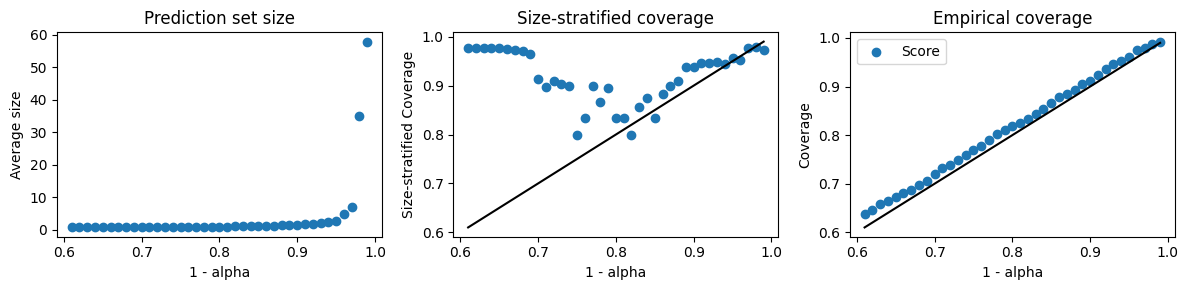

(0.9116883116883117,
 0.6558441558441559,
 2.625536480686695,
 0.023376623376623377)

In [31]:
mapie_score = MapieClassifier(estimator=normalized_model, cv="prefit", method="score", random_state=3)
mapie_score.fit(X_calib, df_calibration['label'])
y_pred_score, y_ps_score = mapie_score.predict(X_test, alpha=alpha)

coverages_score = [
    classification_coverage_score(y_test, y_ps_score[:, :, i])
    for i, _ in enumerate(alpha)
]
widths_mean_score = [
    classification_mean_width_score(y_ps_score[:, :, i])
    for i, _ in enumerate(alpha)
]
adjusted_width_score = [
    adjusted_classification_x_width_score(y_ps_score[:, :, i], np.mean, max_ps_size)
    for i, _ in enumerate(alpha)
]
ssc_score = [
    size_stratified_classification_coverage_score(y_test, y_ps_score[:, :, i])
    for i, _ in enumerate(alpha)
]
plot.plot_coverages_widths(alpha, coverages_score, widths_mean_score, "Score", ssc_score, True, "banking77", "dfcx")

results = cq_stats(y_ps_score[:, :, target_index], y_test, max_ps_size)

write_results('banking77-dfcx-cicc', dataset, intent_classifier, 'cicc', results)
results

In [32]:
2020 / y_ps_score.shape[0], set_size_equals(y_ps_score[:,:,target_index], 0)


(0.6558441558441559, 128)

/Users/floris/Documents/archive/publications/cicc/cicc/src/eval.py:101: UserWarning: Warning: converting a masked element to nan.
  return float(agg_width)


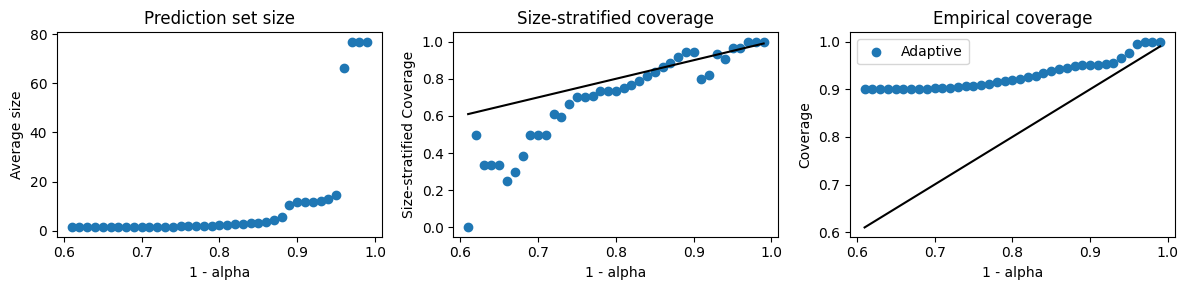

(0.9503246753246753,
 11.765584415584415,
 0.9428251121076233,
 0,
 2.0011198208286674)

In [33]:
mapie_cum = MapieClassifier(estimator=normalized_model, cv="prefit", method="cumulated_score", random_state=3)
mapie_cum.fit(X_calib, df_calibration['label'])
y_pred_cum, y_ps_cum = mapie_cum.predict(X_test, alpha=alpha)

coverages_cum = [
    classification_coverage_score(y_test, y_ps_cum[:, :, i])
    for i, _ in enumerate(alpha)
]
widths_mean_cum = [
    classification_mean_width_score(y_ps_cum[:, :, i])
    for i, _ in enumerate(alpha)
]
adjusted_width_cum = [
    adjusted_classification_x_width_score(y_ps_cum[:, :, i], np.mean, max_ps_size)
    for i, _ in enumerate(alpha)
]
ssc_cum = [
    size_stratified_classification_coverage_score(y_test, y_ps_cum[:, :, i])
    for i, _ in enumerate(alpha)
]
plot.plot_coverages_widths(alpha, coverages_cum, widths_mean_cum, "Adaptive", ssc_cum, True, "banking77", "dfcx")
coverages_cum[target_index], widths_mean_cum[target_index], ssc_cum[target_index], set_size_equals(y_ps_cum[:,:,target_index], 1), adjusted_width_cum[target_index]

/Users/floris/Documents/archive/publications/cicc/cicc/src/eval.py:101: UserWarning: Warning: converting a masked element to nan.
  return float(agg_width)


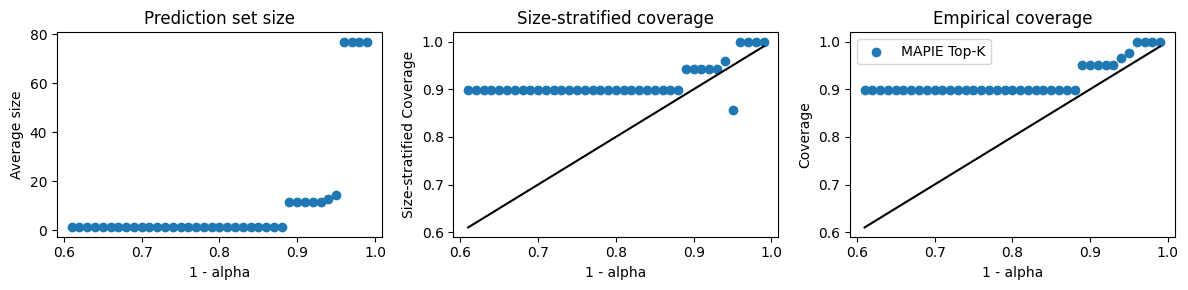

(0.9503246753246753,
 11.765584415584415,
 0.9428251121076233,
 0,
 2.0011198208286674)

In [34]:
mapie_topkmapie = MapieClassifier(estimator=normalized_model, cv="prefit", method="top_k", random_state=3)
mapie_topkmapie.fit(X_calib, df_calibration['label'])
y_pred_topkmapie, y_ps_topkmapie = mapie_topkmapie.predict(X_test, alpha=alpha)

coverages_topkmapie = [
    classification_coverage_score(y_test, y_ps_topkmapie[:, :, i])
    for i, _ in enumerate(alpha)
]
widths_mean_topkmapie = [
    classification_mean_width_score(y_ps_topkmapie[:, :, i])
    for i, _ in enumerate(alpha)
]
adjusted_width_topkmapie = [
    adjusted_classification_x_width_score(y_ps_topkmapie[:, :, i], np.mean, max_ps_size)
    for i, _ in enumerate(alpha)
]
ssc_topkmapie = [
    size_stratified_classification_coverage_score(y_test, y_ps_topkmapie[:, :, i])
    for i, _ in enumerate(alpha)
]
plot.plot_coverages_widths(alpha, coverages_topkmapie, widths_mean_topkmapie, "MAPIE Top-K", ssc_topkmapie, True, "banking77", "dfcx")
coverages_topkmapie[target_index], widths_mean_topkmapie[target_index], ssc_topkmapie[target_index], set_size_equals(y_ps_topkmapie[:, :, target_index], 1), adjusted_width_topkmapie[target_index]

/Users/floris/Documents/archive/publications/cicc/cicc/src/eval.py:101: UserWarning: Warning: converting a masked element to nan.
  return float(agg_width)


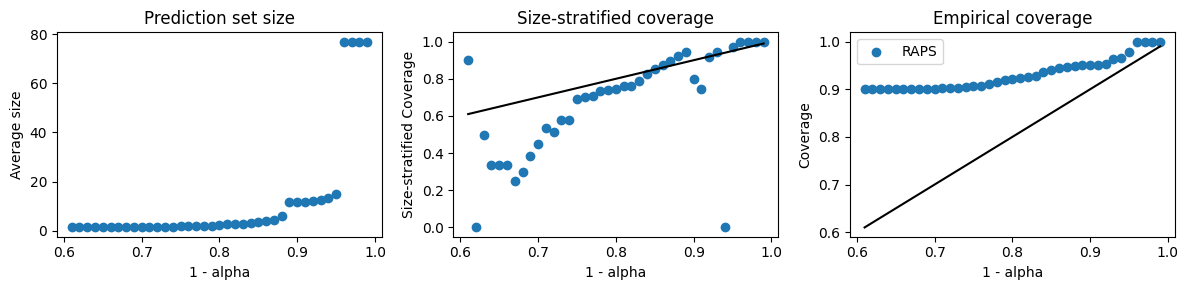

(0.9503246753246753, 11.766233766233766, 0.8, 0, 2.001866368047779)

In [35]:
mapie_raps = MapieClassifier(estimator=normalized_model, cv="prefit", method="raps")
mapie_raps.fit(X_calib, df_calibration['label'])
y_pred_raps, y_ps_raps = mapie_raps.predict(X_test, alpha=alpha)

coverages_raps = [
    classification_coverage_score(y_test, y_ps_raps[:, :, i])
    for i, _ in enumerate(alpha)
]
widths_mean_raps = [
    classification_mean_width_score(y_ps_raps[:, :, i])
    for i, _ in enumerate(alpha)
]
adjusted_width_raps = [
    adjusted_classification_x_width_score(y_ps_raps[:, :, i], np.mean, max_ps_size)
    for i, _ in enumerate(alpha)
]
ssc_raps = [
    size_stratified_classification_coverage_score(y_test, y_ps_raps[:, :, i])
    for i, _ in enumerate(alpha)
]
plot.plot_coverages_widths(alpha, coverages_raps, widths_mean_raps, "RAPS", ssc_raps, True, "banking77", "dfcx")
coverages_raps[target_index], widths_mean_raps[target_index], ssc_raps[target_index], set_size_equals(y_ps_raps[:, :, target_index], 1), adjusted_width_raps[target_index]

In [36]:
# heuristic 1: select all classes above a certain cutoff or the top-5 if there are none
topk_cutoff = TopKCutoffSelector(estimator=raw_model, cutoff=1-target_alpha, k=5)
y_ps_h1 = topk_cutoff.predict(X_test)
results = cq_stats(y_ps_h1, y_test, max_ps_size)
write_results('banking77-dfcx-h1', dataset, intent_classifier, 'h1', results)
results

(0.9522727272727273,
 0.7103896103896103,
 4.791479820627803,
 0.26785714285714285)

In [37]:
top_95 = HeuristicCutoffSelector(estimator=raw_model, cutoff=1-target_alpha)
y_ps_h2 = top_95.predict(X_test)
results = cq_stats(y_ps_h2, y_test, max_ps_size)
write_results('banking77-dfcx-h2', dataset, intent_classifier, 'h2', results)
results

(0.8993506493506493,
 0.977922077922078,
 2.264705882352941,
 0.0003246753246753247)

In [38]:
cq_stats(y_ps_h2, y_test, max_ps_size)

(0.8993506493506493,
 0.977922077922078,
 2.264705882352941,
 0.0003246753246753247)

In [39]:
topk_5 = TopKSelector(estimator=raw_model, k=5)
y_ps_h3 = topk_5.predict(X_test)

results = cq_stats(y_ps_h3, y_test, max_ps_size)
write_results('banking77-dfcx-h3', dataset, intent_classifier, 'h3', results)
results

(0.9720779220779221, 0.0, 5.0, 1.0)

NameError: name 'to_plot' is not defined

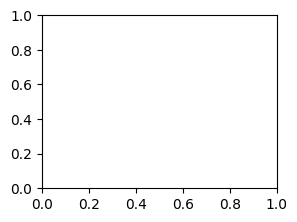

In [40]:
fig, ax = plt.subplots(1, 1, figsize=plot.fig_dim_1)

for (resultset, label, style, color) in to_plot:
    if len(label) > len('heuristic') and label[:len('heuristic')] == 'heuristic':
        to_plot_result = resultset
    else:
        to_plot_result = resultset[:, :, target_index]
    ax.plot(
        np.cumsum([set_size_equals(to_plot_result, i) for i in range(78)]),
        label=label,
        linestyle=style,
        color=color,
        linewidth=3,
        alpha=.8)
    # ax.set_xscale('log')
plt.legend(handlelength=2.5)
plt.xlabel('Set size <')
plt.ylabel('# samples')
plt.title('BANKING77, DFCX'.format(target_alpha))
plt.legend(handlelength=3.5)
plt.tight_layout()
plt.savefig('results/cum_set_size_BANKING77_DFCX.pdf', dpi=1200)

In [48]:
pd.Series(np.cumsum([set_size_equals(y_ps_cum[:, :, target_index], i) for i in range(N_INTENTS+1)])).to_csv(f'results/cum_{dataset}_{intent_classifier}.csv')

In [47]:
[set_size_equals(y_ps_cum[:, :, target_index], i) for i in range(N_INTENTS+1)]

[0,
 0,
 2676,
 3,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 401]